# UTinvert: A workflow for performing rigorous surface-wave inversion.

> Joseph P. Vantassel, The University of Texas at Austin

## About UTinvert

`UTinvert` is the name given to a systematic procedure for inverting surface-wave dispersion data which addresses the inverse problem's non-linearity and non-uniqueness. The workflow was developed by Joseph P. Vantassel under the supervision of Brady R. Cox at the University of Texas at Austin. The recommendations with their justifications are summarized in the paper cited below. We ask that you please cite this paper if you use this notebook or `swipp` in your research.

>Citation Forthcoming

## About `swipp`

`swipp` is the engine behind the `UTinvert` workflow which allows for rapid surface wave inversion pre- and post-processing. This notebook is __an__ example of a workflow that can be built using `swipp`. More information about `swipp` can be found at the [Github repository](https://github.com/jpvantassel/swipp). This notebook and `swipp` were built and are maintained by Joseph P. Vantassel, under the supervision of Brady R. Cox at the University of Texas at Austin.

## About this notebook

This notebook has four parts:

1. [Defining the inversion target](#Defining-the-Inversion-Target)
2. [Selecting the inversion parameterizations](#Selecting-the-Inversion-Parameterizations)
3. [Running the inversion](#Running-the-Inversion)
4. [Post-processing the inversion results](#Post-processing-the-Inversion-Results)

__This notebook is intended as a convenient tool to expedite surface-wave inversion, however it is paramount that the user have some working knowledge of surface-wave inverison to understand what they are doing and be able to extract meaningful results. We strongly recommend that this notebook is not treated as "black-box" software and so have amassed a wealth of documentation and references  to educate users on the various components of [`swipp`](https://github.com/jpvantassel/swipp) and [surface-wave inversion]() generally__.

All the best 

\- Joe

In [2]:
import swipp
import numpy as np
import matplotlib.pyplot as plt
import glob, re, os
import ipywidgets as widgets

def plotter(tar):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,3), dpi=150)
    tar.plot(x="frequency", y="velocity", ax=axs[0])
    tar.plot(x="wavelength", y="velocity", ax=axs[1])
    axs[1].set_ylabel("")
    axs[1].legend()
    
def on_button_click(*args, **kwargs):
    global tar
    click.clear_output()
    button.description = 'Plotting'
    with click:
        if tar.is_no_velstd():
            tar.setcov(ecov.value)
        else:
            tar.setmincov(ecov.value)
        plotter(tar)
        button.description = 'Done'

def change_options(*args):
    global tar
    tar=swipp.Target.from_csv(fname.value)
    # If Vel_std does not exist -> prompt for COV
    if tar.is_no_velstd(): 
        ecov.description = 'COV:'
        ecov.options = {'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}
    # If Vel_std exists -> continue all is good
    else: 
        ecov.description = 'Min COV:'
        ecov.options = {'Provided':0, 'COV=0.05':0.05,'COV=0.075':0.075,'COV=0.1':0.1}

## Defining the Inversion Target

### Importing the Experimental Dispersion Data

1. Use the left dropdown menu to select the file with your experimental disperison data.
2. If no uncertainty is provided use the right dropdown menu to select an appropraite coefficient of variation (COV).
3. Press `Load` when ready.
4. Review the figure to ensure your data has loaded correctly, then proceed to the next cell.

[Back to top](#About-this-notebook)

Output()

Output()

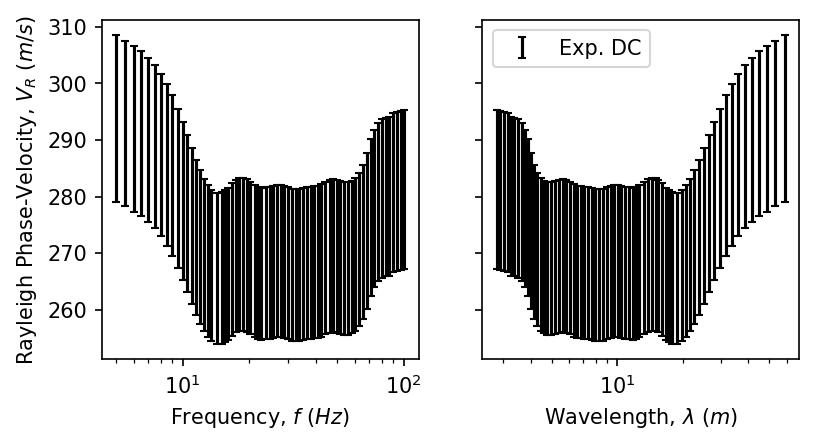

In [3]:
csvs = glob.glob('*.csv')
init = widgets.Output()
fname = widgets.Dropdown(options=['Select Experimental Dispersion Data File'] + csvs,
                        description='File Name:')
ecov=widgets.Dropdown(options={' ':None}, description='COV')
button=widgets.Button(description='Load')
fname.observe(change_options,names='value'); display(init)
ui=widgets.HBox(children=[fname, ecov, button])
click = widgets.Output(); button.on_click(on_button_click); display(ui,click)

### Resampling the Experimental Disperison

1. Select the domain in which you wish to resample. _Wavelength is recommended._
2. Select whether you want to resample in log or linear space. _Log is recommended._
3. Select the `minimum`, `maximum`, and `number` of points. _20-30 points are recommended._
4. Press `Load` after making your selections.
4. Review the figure to ensure your data has been resampled correctly, then proceed to the next cell.

[Back to top](#About-this-notebook)

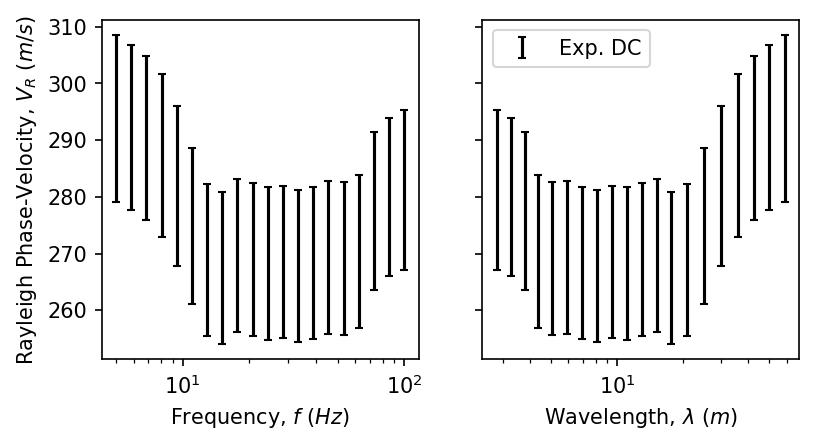

In [4]:
domain = 'frequency'   # 'frequency' or 'wavelength'
res_type = 'log'       # 'log' or 'linear'
pmin = 5               # minimum value
pmax = 100             # maximum value
pn = 20                # number of samples

# Resample
tar.resample(pmin=pmin, pmax=pmax, pn=pn, res_type=res_type, domain=domain, inplace=True)

# Save to Disk
if os.path.isdir("Targets/")==False:
    os.mkdir("Targets/")
tar.to_target("Targets/Tar01", version="2")
plotter(tar)

## Selecting the Inversion Parameterizations

1. Enter upper and lower limits for `vp`, `vs`, `Poisson's Ratio`, and `mass density`. 
2. Select the number of Layering Ratio or Layering by Number inversions you would like to consider, use `ctrl+click` to select multiple.
3. Review your selections, then proceed to and run the next cell.
 
__Be cautious when performing your selections as they can strongly bias your inversion's final result if not done properly!__
 
[Back to top](#About-this-notebook)

In [5]:
vpstep = 100
vpMin = widgets.FloatText(value=100, step=vpstep, description=r'\(V_{p,min} (m/s)\)')
vpMax = widgets.FloatText(value=2500, step=vpstep, description=r'\(V_{p,max} (m/s)\)')
vpRev = widgets.Checkbox(value=True,description='No Vp Reversal')

vstep = 50
vMin = widgets.FloatText(value=round(min(tar.velocity)*0.9,0), step=vstep, description=r'\(V_{s,min} (m/s)\)')
vMax = widgets.FloatText(value=round(max(tar.velocity)*1.1,0), step=vstep, description=r'\(V_{s,max} (m/s)\)')
vRev = widgets.Checkbox(value=True,description='No Vs Reversal')

nustep = 0.05
nuMin = widgets.FloatText(value=0.15, step=nustep, description=r'\(\nu_{min}\)')
nuMax = widgets.FloatText(value=0.5, step=nustep, description=r'\(\nu_{max}\)')
nuRev = widgets.Checkbox(value=True,description='No PR Increase')

rhstep = 0.05
rhMin = widgets.FloatText(value=2000, step=rhstep, description=r'\(\rho_{min} (kg/m^{3})\)')
rhMax = widgets.FloatText(value=2500, step=rhstep, description=r'\(\rho_{max} (kg/m^{3})\)')
rhRev = widgets.Checkbox(value=True,description='No Rho Decrease')

hvstep = 0.01
ellMean = widgets.FloatText(value=None, step=hvstep, description=r'\(f_{0, H/V}\)')
ellStd = widgets.FloatText(value=None, step=nustep, description=r'\(\sigma_{0, H/V}\)')
useEll= widgets.Checkbox(value=False,description='Use H/V Peak')

LRs = widgets.SelectMultiple(description='By Ratio (' + r'\(\Xi\)' + ')', 
                             options=[('LR: 1.2',1.2), ('LR: 1.3',1.3), ('LR: 1.5',1.5), ('LR: 2.0',2.0), ('LR: 2.5',2.5),
                                      ('LR: 3.0',3.0), ('LR: 3.5',3.5), ('LR: 5.0',5.0), ('LR: 6.0',6.0), ('LR: 7.0',7.0)],
                             layout=widgets.Layout(height='200px'))
LNs = widgets.SelectMultiple(description='By Number', 
                             options=[('LN: 3',3),('LN: 4',4),('LN: 5',5),
                                      ('LN: 6',6),('LN: 7',7),('LN: 8',8),('LN: 9',9),
                                      ('LN: 10',10), ('LN: 15',15), ('LN: 20',20),],
                             layout=widgets.Layout(height='200px'))

Vs = widgets.VBox([vMin, vMax, vRev])
Vp = widgets.VBox([vpMin, vpMax, vpRev])
Nu = widgets.VBox([nuMin, nuMax, nuRev])
Rh = widgets.VBox([rhMin, rhMax, rhRev])
ui_new = widgets.VBox([widgets.HBox([Vp, Nu]), widgets.HBox([Vs, Rh]), widgets.HBox([LRs, LNs])])
display(ui_new)

### Write Parameterizations to Disk

[Back to top](#About-this-notebook)

In [6]:
wmin, wmax = min(tar.wavelength), max(tar.wavelength)

# Parameterize Vp, Poisson's Ratio, and Mass Density
rh = swipp.Parameter.from_fx(2000)
pr = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=nuMin.value, par_max=nuMax.value, par_rev=nuRev.value)
vp = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=3, par_min=vpMin.value, par_max=vpMax.value, par_rev=vpRev.value)

if os.path.isdir("Params/")==False:
    os.mkdir("Params/")

# Parameterize Vs using Layering by Number (LN)
for ln in LNs.value:
    vs = swipp.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=ln, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value)
    par=swipp.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"Params/LN{ln}", version="2")
    
# Parameterize Vs using Fixed-Thickness Layers (FTL)
dmax=20
for ftl in [10, 20]:
    vs = swipp.Parameter.from_ftl(nlayers=ftl, thickness=dmax/ftl, par_min=vMin.value, par_max=vMax.value, par_rev=vRev.value)
    par=swipp.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"Params/FTL{ftl}",version="2")

## Running the Inversion

Forthcoming!

[Back to top](#About-this-notebook)

## Post-processing the Inversion Results

[Back to top](#About-this-notebook)

### Importing the Data

[Back to top](#About-this-notebook)

fname = Text\Mod120_LN4_Sd2_DC.txt, is empty skipping!


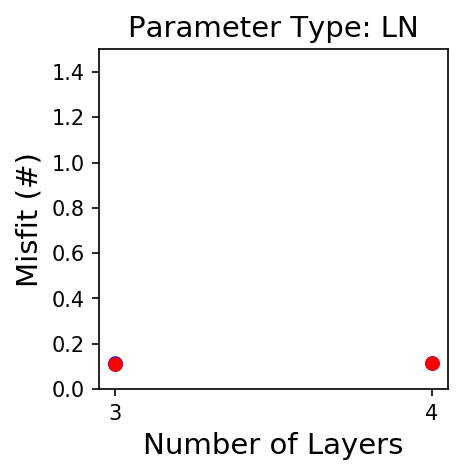

In [7]:
ndc = 5             # Number of dispersion curves, may use "all"
nrayleigh = 2       # Number of rayleigh modes, may use "all"
nlove = 0           # Number of love modes, may use "all"
ngm = 5             # Number of ground models, may use "all"

fnames = glob.glob('Text/*_DC.txt')
fnames.sort(key=lambda x: int(re.findall(r".*[\\/].*_.*[LF][TRN][IL]?(\d+)_Sd\d+_DC.txt$",x)[0]))

dcs, gms = {}, {}
for fname in fnames:
    filename, partype, parnumber, seed = re.findall(r".*[\\/](.*_.*([LF][TRN][IL]?)(\d+)_Sd(\d+)_DC.txt)$", fname)[0]
    
    # Divide LR by 10
    if partype in ['LR']:
        parnumber = str(int(parnumber)/10)
    
    # Save by parameterization
    if partype not in dcs.keys():
        dcs.update({partype:{}})
        gms.update({partype:{}})
        firstpass = True
        
    # Save by parameterization number        
    if parnumber not in dcs[partype].keys():
        dcs[partype].update({parnumber:{}})
        gms[partype].update({parnumber:{}})
        
    # Save by seed
    if os.path.getsize(fname) == 0:
        print(f"fname = {fname}, is empty skipping!")
    else:
        dcs[partype][parnumber].update({seed:swipp.DispersionSuite.from_geopsy(fname=fname, ndc=ndc, 
                                                                               nrayleigh=nrayleigh, nlove=nlove)})
        gms[partype][parnumber].update({seed:swipp.GroundModelSuite.from_geopsy(fname=fname[:-6]+"GM.txt", nmodels=ngm)})

    
ncols = len(list(dcs.keys()))
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(3*ncols,3), dpi=150)
axs = [axs] if type(axs) != list else axs
bestseed = {}
for ax, partype in zip(axs, dcs):
    bestseed.update({partype:{}})
    for parnumber in dcs[partype]:
        seeds, misfits = [], []
        for seed in dcs[partype][parnumber].keys():
            seeds.append(seed)
            misfits.append(dcs[partype][parnumber][seed].misfits[0])
            ax.plot(parnumber, misfits[-1], 'bo')
        bestseed[partype].update({parnumber:seeds[misfits.index(min(misfits))]})
        ax.plot(parnumber, min(misfits),'ro')
        ax.set_ylim((0,1.5))
        ax.set_ylabel('Misfit (#)', fontsize=14)
        ax.set_xlabel('Number of Layers', fontsize=14)
        ax.set_title("Parameter Type: "+partype, fontsize=14)
plt.show()

### General Settings

[Back to top](#About-this-notebook)

In [8]:
colors = ["#588c7e","#e6c833","#f2ae72","#e97816","#a366ff"]

### Plotting Dispersion

[Back to top](#About-this-notebook)

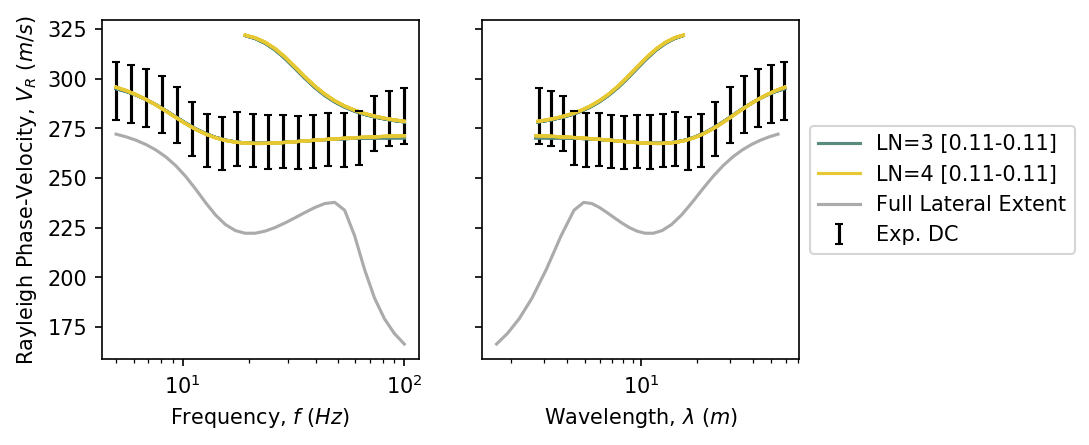

In [9]:
ndc = 5       # Number of "best" dispersion curves to plot, may use "all".
nray = 2      # Number of Rayleigh-wave modes to plot, may use "all".
# nlov = 0      # Number of Love-wave modes to plot, may use "all".

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3), dpi=150)

# Plot the Theoretical Modes of Inversion Ground Models.
color_id = 0
for partype in dcs:
    for parnumber in dcs[partype]:
        best = bestseed[partype][parnumber]
        suite = dcs[partype][parnumber][best]
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ndc)}"
        
        color = colors[color_id]
        for dc_count, dcset in enumerate(suite):
            for mode in range(nray):
                try:
                    dc = dcset.rayleigh[mode]
                    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label)
                    label=None
                    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label)
                except KeyError:
                    print(f"Could not find mode {mode}.")                    
            if dc_count+1 == ndc:
                break
        color_id += 1
                
# Plot the Theoretical Modes of the True Solution
nray = 1      # Number of Rayleigh-wave modes to plot, may use "all".
nlov = 0      # Number of Love-wave modes to plot, may use "all".
true = swipp.DispersionSet.from_geopsy(fname="output.txt", nrayleigh=nray, nlove=nlov)
color = "#ababab"

label = f"Full Lateral Extent"
for mode, dc in true.rayleigh.items():
    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label)
    label=None
    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label)
    
# Plot the Experimental Dispersion Curve
ax = axs[0]
tar.plot(ax=ax)

ax = axs[1]
tar.plot(ax=ax, x="wavelength")
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
ax.set_ylabel("")
ax.set_yticklabels("")

plt.show()

### Plotting Vs

[Back to top](#About-this-notebook)

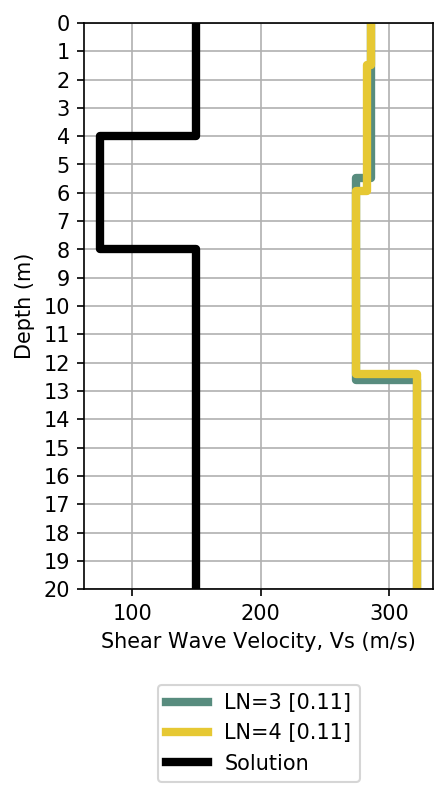

In [13]:
# True Profile
tk=[4,4,0]          # Thickness (m)
vs=[150,75,150]     # Shear-wave velocity (m/s)
vp=[300,150,300]    # Compression-wave velocity (m/s)
rh=[2000]*3         # Mass density (kg/m3)

true=swipp.GroundModel(thickness=tk, vp=vp, vs=vs, density=rh)

# Inverted GroundModels
ngm = 1             # Number of GroundModels

npars = len(dcs.keys())
fig, axs = plt.subplots(nrows=1, ncols=npars, sharey=True, sharex=True, figsize=(3*npars, 5), dpi=150)
axs = [axs] if type(axs) != list else axs
for partype, ax in zip(gms, axs):          
    for parnumber, color in zip(gms[partype], colors):
        best = bestseed[partype][parnumber]
        suite = gms[partype][parnumber][best]
        label = f"{partype}={parnumber} {suite.misfit_repr(ngm)}"
            
        for gm in suite[:ngm]:
            ax.plot(gm.vs2, gm.depth, color=color, linewidth=4, label=label)
            label=None
        
    ax.plot(true.vs2, true.depth,
            color='black', linewidth = 4, label='Solution')
    ax.set_ylim([20,0])
    ax.set_xlabel('Shear Wave Velocity, Vs (m/s)')
    ax.set_ylabel('Depth (m)')
    ax.grid(which='both')
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')
    ax.set_yticks(np.arange(0, 21, 1))

plt.show()